In [1]:
from PIL import Image 
import os, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import misc, ndimage
from numpy import array, argmax
from keras.utils import to_categorical
import scipy.io as sio
import h5py
%matplotlib inline 


c:\users\giedrius\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# SVHN data
----------------------

Street View House Numbers [(SVHN)](http://ufldl.stanford.edu/housenumbers/) is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. (second sentence)



## 1) Read SVHN data

Read SVHN metadata from h5 Matlab file.

In [2]:
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    # getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    # getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    # getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]
        #return [self.getDigitStructure(i) for i in range(100)]

# Return a restructured version of the dataset (one structure by boxed digit).
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

Write SVHN metadata into pickle files.

In [3]:
#Train data
train_data__path = os.path.join("SVHN", "train", 'digitStruct.mat')
train_pickle_file = os.path.join("SVHN", "train", 'train.pickle')

dsf = DigitStructFile(train_data__path)
train_data = dsf.getAllDigitStructure_ByDigit()

with open(train_pickle_file, 'wb') as f:
    pickle.dump(train_data, f, protocol=pickle.HIGHEST_PROTOCOL)

    
#Test data
test_data__path = os.path.join("SVHN", "test", 'digitStruct.mat')
test_pickle_file = os.path.join("SVHN", "test", 'test.pickle')

dsf = DigitStructFile(test_data__path)
test_data = dsf.getAllDigitStructure_ByDigit()

with open(test_pickle_file, 'wb') as f:
    pickle.dump(test_data, f, protocol=pickle.HIGHEST_PROTOCOL)

    
#Extra data
extra_data__path = os.path.join("SVHN", "extra", 'digitStruct.mat')
extra_pickle_file = os.path.join("SVHN", "extra", 'test.pickle')

dsf = DigitStructFile(extra_data__path)
extra_data = dsf.getAllDigitStructure_ByDigit()

with open(extra_pickle_file, 'wb') as f:
    pickle.dump(extra_data, f, protocol=pickle.HIGHEST_PROTOCOL)


Load SVHN metadata from pickle files.

In [4]:
#Read pickle files
pickle_file = os.path.join("SVHN","extra", 'extra.pickle')
with open(pickle_file, 'rb') as f:
    extra_data = pickle.load(f)
    
pickle_file = os.path.join("SVHN","train", 'train.pickle')
with open(pickle_file, 'rb') as f:
    train_data = pickle.load(f)
    
pickle_file = os.path.join("SVHN","test", 'test.pickle')
with open(pickle_file, 'rb') as f:
    test_data = pickle.load(f)

## 2) Explore data

In this section, we will visualize and look at some SVHN dataset properties. 
#### 2.1) SVHN dataset size
SVHN has three datasets: train, test, and extra. 

In [5]:
# Dataset size:
print('Training size:', len(train_data))
print('Testing size:',len(test_data))
print('Extra images:',len(extra_data))

Training size: 33402
Testing size: 13068
Extra images: 202353


#### 2.2) Number of digits distribution in SVHN

In [6]:
def get_number_of_digits(data):
    digits = [0]*6
    
    for i in range(len(data)):
        
        digit_num = len(data[i]['boxes'])
        if digit_num > 5:
            digits[5] += 1
        else:
            digits[digit_num-1] += 1
        
    return digits

In [7]:
train_digits = get_number_of_digits(train_data)
test_digits = get_number_of_digits(test_data)
extra_digits = get_number_of_digits(extra_data)

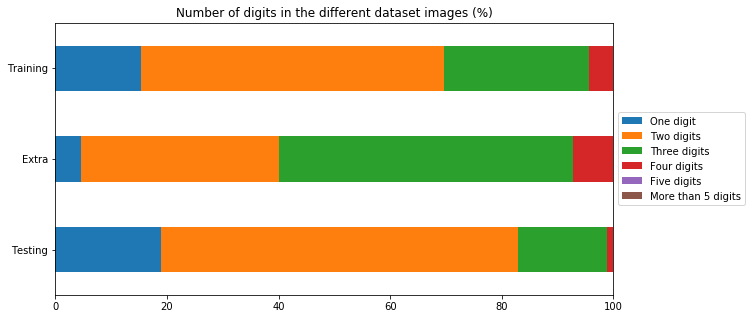

In [8]:
df = pd.DataFrame(np.vstack((test_digits / np.sum(test_digits) * 100,    \
                             extra_digits / np.sum(extra_digits) * 100,  \
                             train_digits / np.sum(train_digits) * 100)),\
                  columns=['One digit', 'Two digits', 'Three digits', 'Four digits', 'Five digits', 'More than 5 digits'],\
                  index=['Testing', 'Extra', 'Training'])
f = plt.figure(1, figsize = (10,5))
plt.title('Number of digits in the different dataset images (%)', color='black')
df.plot.barh(stacked=True, ax=f.gca())
axes = plt.gca()
axes.set_xlim([0,100])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In barplot above we see that most of the images contain one, two or three digits. Therefore for simplicity, we are going to classify only the first three digits in the images and discard images which contains more than that. 

#### 2.3)  Images size bacis statistics. 

In [9]:
def get_image_sizes(data, path):
    im_sizes = []
    
    for i in range(len(data)):
        #skip pictures which contains more that 3 digits
        if len(data[i]["boxes"]) > 3:
            continue
        image_path = os.path.join(path, data[i]['filename'])
        image = Image.open(image_path)
        im_sizes.append(image.size)
 
    return  np.array(im_sizes)
        

In [10]:
train_sizes = get_image_sizes(train_data,  os.path.join("SVHN","train"))
test_sizes = get_image_sizes(test_data,  os.path.join("SVHN","test"))
extra_sizes = get_image_sizes(extra_data,  os.path.join("SVHN","extra"))

In [11]:
d = {'Max. Height' : pd.Series([np.amax(train_sizes[:,1]), np.amax(test_sizes[:,1]), np.amax(extra_sizes[:,1])], index=['Training', 'Testing', 'Extra']),
     'Min. Height' : pd.Series([np.amin(train_sizes[:,1]), np.amin(test_sizes[:,1]), np.amin(extra_sizes[:,1])], index=['Training', 'Testing', 'Extra']),
     'Avg. Height' : pd.Series([np.mean(train_sizes[:,1]), np.mean(test_sizes[:,1]), np.mean(extra_sizes[:,1])], index=['Training', 'Testing', 'Extra']),
     'Max. Width' : pd.Series([np.amax(train_sizes[:,0]), np.amax(test_sizes[:,0]), np.amax(extra_sizes[:,0])], index=['Training', 'Testing', 'Extra']),
     'Min. Width' : pd.Series([np.amin(train_sizes[:,0]), np.amin(test_sizes[:,0]), np.amin(extra_sizes[:,0])], index=['Training', 'Testing', 'Extra']),
     'Avg. Width' : pd.Series([np.mean(train_sizes[:,0]), np.mean(test_sizes[:,0]), np.mean(extra_sizes[:,0])], index=['Training', 'Testing', 'Extra'])}
df = pd.DataFrame(d)
df

,Avg. Height,Avg. Width,Max. Height,Max. Width,Min. Height,Min. Width
Training,57.574848,128.133425,501,876,12,25
Testing,71.372214,172.003328,516,1083,13,31
Extra,60.672576,99.094641,415,668,13,22


In [ ]:
some comment

In [12]:
train_hypotenuse = np.round(np.sqrt(train_sizes[:,0] ** 2 + train_sizes[:,1] ** 2), 2)
extra_hypotenuse = np.round(np.sqrt(extra_sizes[:,0] ** 2 + extra_sizes[:,1] ** 2), 2)
test_hypotenuse = np.round(np.sqrt(test_sizes[:,0] ** 2 + test_sizes[:,1] ** 2), 2)

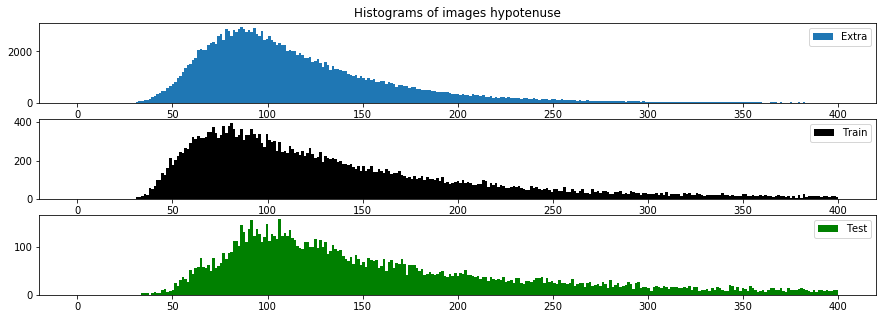

In [13]:
bins = np.linspace(0, 400, 300)

plt.figure(figsize=(15,5))
plt.subplot(3, 1, 1)
plt.hist(extra_hypotenuse, bins=bins, label = "Extra") 

plt.title("Histograms of images hypotenuse")
plt.legend(loc='upper right')

plt.subplot(3, 1, 2)
plt.hist(train_hypotenuse, bins=bins, label = "Train", color = "black")
plt.legend(loc='upper right')

plt.subplot(3, 1, 3)
plt.hist(test_hypotenuse, bins=bins, label = "Test", color ="green")
plt.legend(loc='upper right')

plt.show()

From histogram above we see that test images are a bit better quality than extra and training images.

#### 2.4) Now, let's look at some images.

In [14]:
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

def display_images(data, indexes = [], subplos_in_row = 5, fig_size= [12,12]):
    fig = plt.figure(figsize=(fig_size[0], fig_size[1]), dpi=80) 
    #if dont input array indexes then pick random ones
    if len(indexes) is 0:
        indexes = random.sample(range(len(data)), 25)
    sub_rows = len(indexes) // subplos_in_row + len(indexes) % subplos_in_row
    i = 0
    for ind in indexes:
        plt.subplot(sub_rows, subplos_in_row,i+1)
        #construct label
        label = ""
        for box in range(len(data[ind]["boxes"])):
            if isclose(data[ind]["boxes"][box]["label"],10):
                label += "0"
            else:
                label += str(data[ind]["boxes"][box]["label"])[0] 
        plt.title(label)    
        image_path = os.path.join("SVHN","train",data[ind]['filename'])
        image = Image.open(image_path).resize([64,64])
        plt.imshow(image)
        plt.tight_layout()
        i += 1
    plt.show()

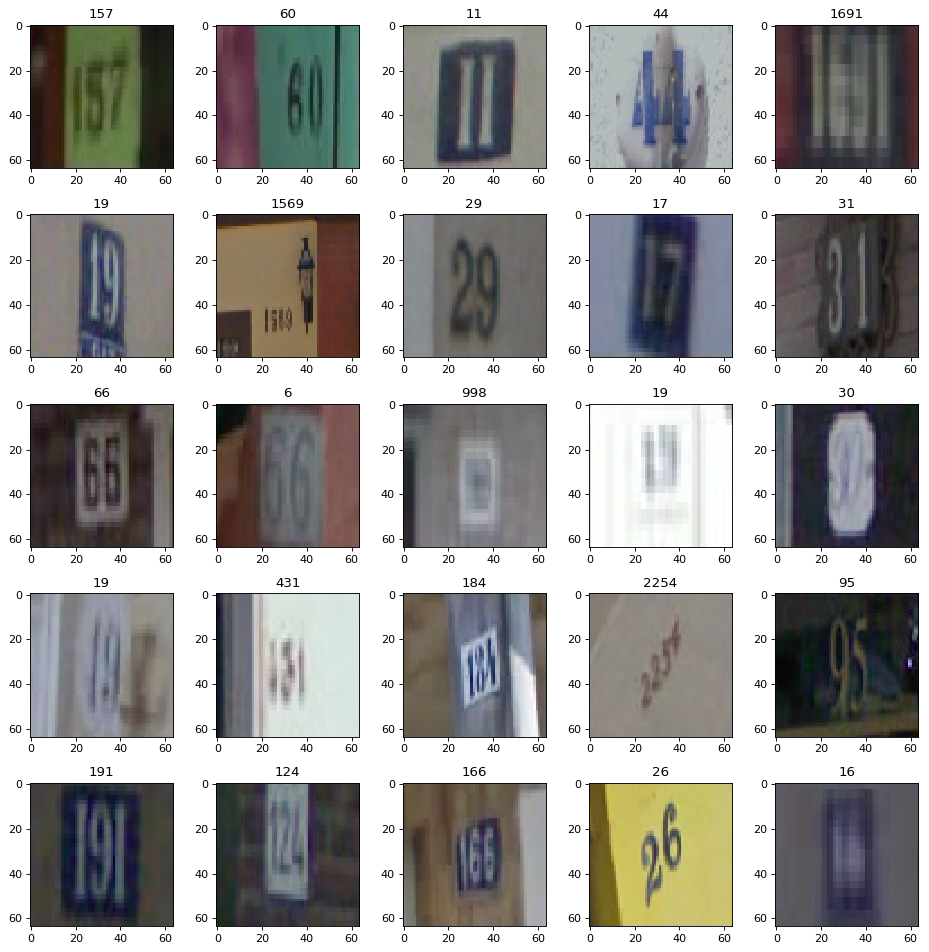

In [15]:
display_images(train_data, subplos_in_row=5)

By looking at SVHN images, I had noticed that a few images were mislabeled with 0 instead of the real label. Therefore, all images which first house number digit is labeled as zero we are going to remove from the datasets. All such images from training data are displayed below.     

In [16]:
indexes = []
for i in range(len(train_data)):
    if isclose(train_data[i]["boxes"][0]["label"],  10):
        indexes.append(i)

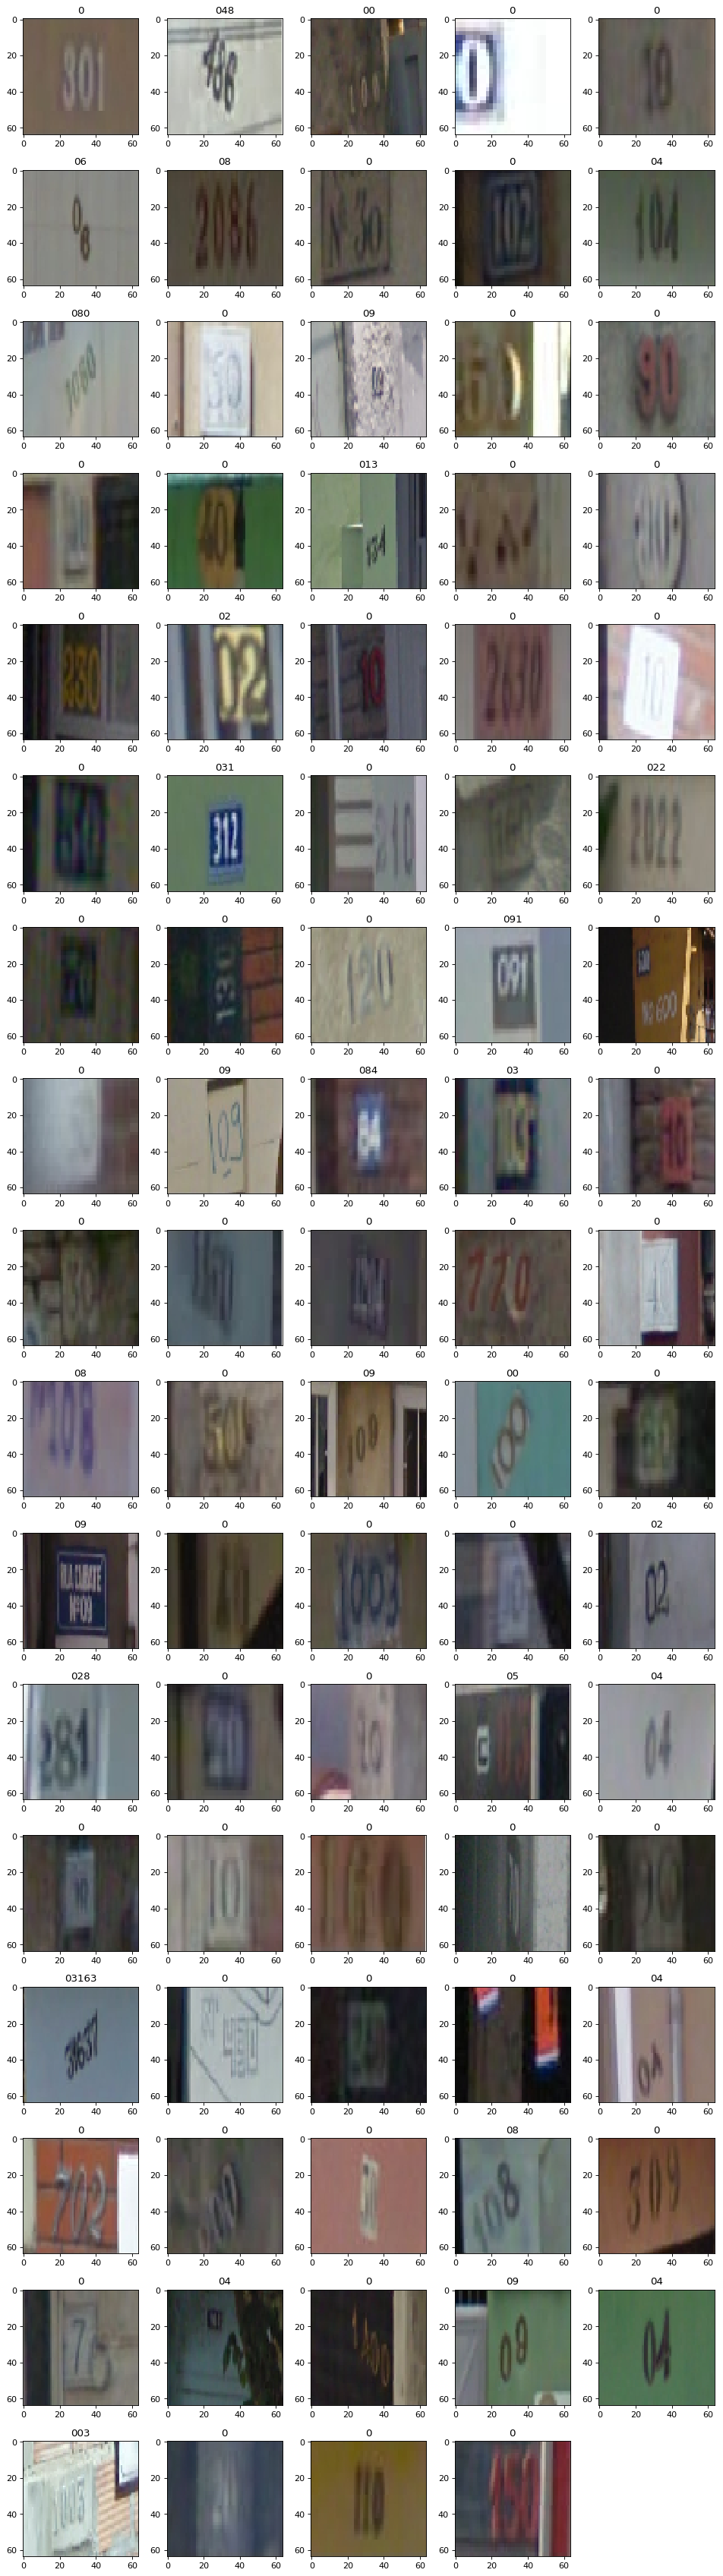

In [17]:
display_images(train_data, indexes, fig_size=[12,50])

## 3) Preprocess data for modeling

#### 3.1) Test and validation dataset 
For model training  and validation we are going to use train extra datasets. Firstly we'll merge them and then we'll create homogenous training/validation datasets. We'll use 10 000 images for model validation.


In [18]:
val_size = 10000   #Set valationation dataset length to 10000
n_digits = 3       #We classify images wich conatain not more than 3 digits

In [19]:
digits_size = np.sum([train_digits , extra_digits], axis = 0)[:n_digits]

d = {'Length' : pd.Series(np.round(digits_size,0), index=['One digit', 'Two digit', 'Three digit']),
     'Length, %' : pd.Series(np.round(digits_size / sum(digits_size)* 100,2), index=['One digit', 'Two digit', 'Three digit'])
    }

df = pd.DataFrame(d).transpose()
df

,One digit,Two digit,Three digit
Length,14522.00,89856.00,115480.00
"Length, %",6.61,40.87,52.52


From the table above we see that the merged dataset have only 6.61 % images which contain one digit. We'll double such images in created training dataset (doubled images will be slightly different; a process is documented further in this Jupyter notebook) because we want that our model will classify images, which contains one digit, more accurately and won't misclassify them with images whose contain the second digit. Let's calculate what images (which contains one digit) ratio will be in the merged dataset when we will double images in training data but won't do it in the validation dataset. 

Here  digits_size = $[x_1,x_2,x_3] $<br>
$ x_i $ - images sizes which cointain $i$ digits in merged dataset <br>
$ x'_i $ - images sizes which cointain $i$ digits in extented (with doubled images in training data) merged dataset <br>
$ proc $ - images ratio which cointain one digits in extented (with doubled images in training data) merged dataset 
<br>
<br>
$\begin{cases}(x_1\times(1-proc))\times2 = x'_1 \\
x'_1 / (x'_1 + x_2 + x_3) = proc 
\end{cases} $

Ans: $proc$ = 0.1163,   $ x'_1$ = 25801.8

Let's look at the distributions of a number of digits in training and validation datesets. 

In [21]:
proc = 0.11163
#calculate new images size that contain one digit
del_x = int((proc * np.sum(digits_size) - digits_size[0]) / (1-proc))
digits_size[0] = digits_size[0] + del_x

total_size_str = [ '%d ' % digits_size[i] for i in range(n_digits)]
total_size_str.append("%d" % sum(digits_size))
#calculate validate dataset sizes
val_size = np.round(digits_size/ np.sum(digits_size)*val_size)
val_size_proc = np.round(val_size / sum(val_size)* 100,2)
val_size_str = [ '%d (%2.2f %%)' % (val_size[i], val_size_proc[i]) for i in range(n_digits)]
val_size_str.append("%d" % sum(val_size))
#calculate training dataset sizes
train_size = digits_size - val_size
train_size_proc = np.round(train_size / sum(train_size)* 100,2)
train_size_str = [ '%d (%2.2f %%)' % (train_size[i], train_size_proc[i]) for i in range(n_digits)]
train_size_str.append("%d" % sum(train_size) )

In [22]:
d = {'Total' : pd.Series(total_size_str, index=['One digit', 'Two digit', 'Three digit', 'Total']),
    'Validation' : pd.Series(val_size_str, index=['One digit', 'Two digit', 'Three digit', 'Total']),
     'Training' : pd.Series(train_size_str, index=['One digit', 'Two digit', 'Three digit', 'Total'])
    }

df = pd.DataFrame(d).transpose()
df.reindex(['Training', 'Validation', 'Total'])

,One digit,Two digit,Three digit,Total
Training,24685 (11.16 %),85968 (38.88 %),110484 (49.96 %),221137
Validation,1116 (11.16 %),3888 (38.88 %),4996 (49.96 %),10000
Total,25801,89856,115480,231137


Create and save training and validation datesets.

In [23]:
#Set a new path of images.
train_path = os.path.join("SVHN","train")
for i in range(len(train_data)):
    train_data[i]["filename"] = os.path.join(train_path,  train_data[i]['filename']) 

extra_path = os.path.join("SVHN","extra")
for i in range(len(extra_data)):
    extra_data[i]["filename"] = os.path.join(extra_path, extra_data[i]['filename']) 
    
dataset = np.append(train_data, extra_data)

In [24]:
#delete records where digits more then 3 and whre first digit is 0
ind = []
for i in range(len(dataset)):
    if len(dataset[i]['boxes']) > n_digits or isclose(dataset[i]["boxes"][0]["label"],  10):
        ind.append(i)
dataset = np.delete(dataset, ind)

In [25]:
#get digit lengths
digits_len = []
for k in range(len(dataset)):
    digits_len.append(len(dataset[k]["boxes"]))
digits_len = np.array(digits_len)          

In [26]:
#create homogenous training and validations datasets
val_index = []
for i in range(n_digits):
    idx = np.where(digits_len == (i+1))[0]
    idx = np.random.permutation(idx)[:int(val_size[i])] #shuffle index
    val_index = np.array(np.append(val_index,idx), dtype=int)
val_index = np.random.permutation(val_index) #shuffle index
validation_data = dataset[val_index]    
training_data = np.delete(dataset,val_index)

In [27]:
#save training and validations datasets
training_pickle_file = os.path.join("SVHN", 'training.pickle')
validation_pickle_file = os.path.join("SVHN", 'validation.pickle')

with open(training_pickle_file, 'wb') as f:
    pickle.dump(training_data, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(validation_pickle_file, 'wb') as f:
    pickle.dump(validation_data, f, protocol=pickle.HIGHEST_PROTOCOL)


Save proccessed test dataset.

In [28]:
#set new test images path
test_path = os.path.join("SVHN","test")
for i in range(len(test_data)):
    test_data[i]["filename"] = os.path.join(test_path,  test_data[i]['filename']) 

# Remove images which contains more than 3 images or first difit is equal 0
ind = []
for i in range(len( test_data)):
    if len( test_data[i]['boxes']) > n_digits or isclose( test_data[i]["boxes"][0]["label"],  10):
        ind.append(i)
test_data = np.delete( test_data, ind)

#save data
test_pickle_file = os.path.join("SVHN", 'test.pickle')
with open(test_pickle_file, 'wb') as f:
    pickle.dump(test_data, f, protocol=pickle.HIGHEST_PROTOCOL)

#### 3.2) Images preparation for modeling

We'll do the same image preprocess as [Ian J. Goodfellow](https://arxiv.org/abs/1312.6082). Firstly we are going to find the small rectangular bounding box that will contain individual character bounding boxes, then it expand by 30 % in all directions. Secondly, we'll crop the image to that bounding box and resize the crop to 64 × 64 pixels. Lastly, we'll crop a 54 × 54 pixel image from a random location within the 64 × 64 pixel image.<br>
Also, we are going to normalize image by the equation: <br>
<br>
$ \normalsize image_{norm} = \frac{image - 127.5} {255} $

Let's look how these pictures looks like.

In [29]:
pickle_file = os.path.join("SVHN", 'validation.pickle')
with open(pickle_file, 'rb') as f:
    validate_dataset = pickle.load(f)


In [30]:
image_size = 64
data = validate_dataset[51]
# Read image
image_path = data['filename']
image_data = Image.open(image_path)
        
# Get digits bounding boxes and labels
top = []; left = []; height = []; width = []; label = []
for box in data["boxes"]:
    top.append(box['top'])
    left.append(box['left'])
    height.append(box['height'])
    width.append(box['width'])

# Get whole number bounding box
num_top = np.amin(top)
num_left = np.amin(left)
num_height = np.amax(top) + height[np.argmax(top)] - num_top
num_width = np.amax(left) + width[np.argmax(left)] - num_left  
        
# Expanding image by 30%
num_bottom = np.amin([np.ceil(num_top + 1.3 * num_height), image_data.size[1]])
num_right = np.amin([np.ceil(num_left + 1.3 * num_width), image_data.size[0]])
num_top = np.amax([np.floor(num_top - 0.3 * num_height), 0])
num_left = np.amax([np.floor(num_left - 0.3 * num_width), 0])         
        
# Cropping the expanded bounding box 
cropped_image = image_data.crop((int(num_left), int(num_top), int(num_right), int(num_bottom))\
            ).resize([image_size,image_size])
image = np.array(cropped_image)
norm_image = (image -127.5) / 255.0 
#cropp image from expanded cropped image
positions = 3
image_size = 54
new_dataset = np.ndarray(shape=(2+ positions * 2, image_size, image_size, 3), dtype=np.float32)
new_dataset[0, :, :, :] = np.array(image_data.resize([image_size,image_size])) #Primary image
new_dataset[1, :, :, :] = np.array(cropped_image.resize([image_size,image_size])) #cropped expanded image
num_image = 2


width = random.sample(range(10), positions)
heigth = random.sample(range(10), positions)


for j in range(positions):
    new_dataset[num_image, :, :, :] = image[heigth[j]:heigth[j] + image_size, width[j]:width[j]+image_size, :]
    new_dataset[num_image + 1, :, :, :] = norm_image[heigth[j]:heigth[j] + image_size, width[j]:width[j]+image_size, :]
    num_image += 2

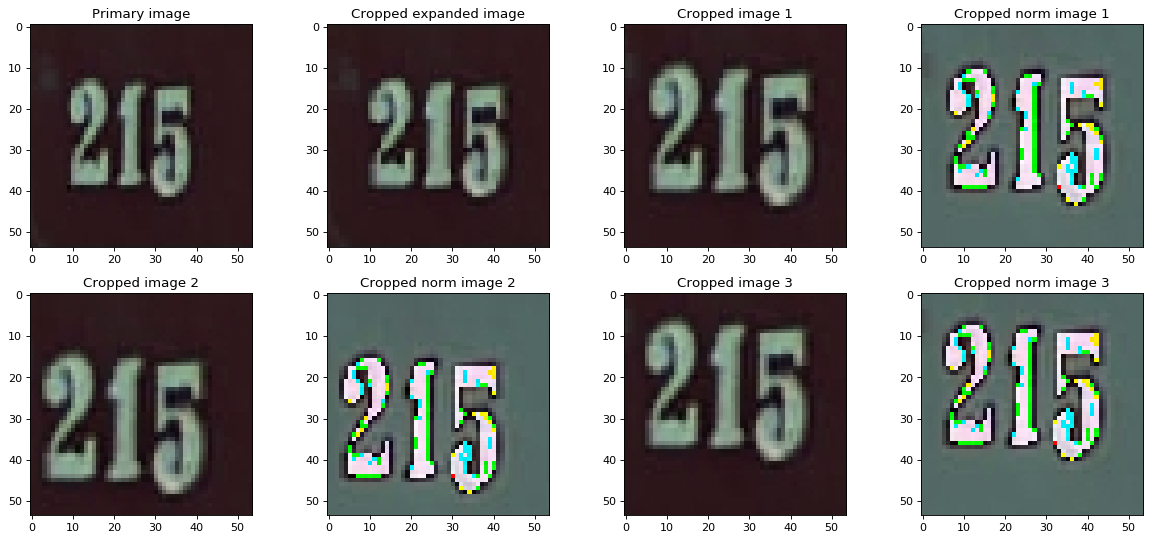

In [31]:
label = ["Primary image", "Cropped expanded image", "Cropped image 1", "Cropped norm image 1", "Cropped image 2", \
         "Cropped norm image 2", "Cropped image 3", "Cropped norm image 3"]
i = 0
fig = plt.figure(figsize=(15, 10), dpi=80) 
for ind in range(len(new_dataset)):
    plt.subplot(3, 4,i+1)
    #construct label
    plt.title(label[i])    
    plt.imshow(new_dataset[ind])
    plt.tight_layout()
    i += 1
plt.show()